## Library

In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import  roc_auc_score, auc

## Data

### Credit Risk Scoring

To be specific, we'll use [credit scoring data](https://github.com/gastonstat/CreditScoring) to build a model that predicts whether a bank should lend loan to a client or not. The bank takes these decisions based on the historical record.

In the credit scoring classification problem,

- if the model returns 0, this means, the client is very likely to payback the loan and the bank will approve the loan.
- if the model returns 1, then the client is considered as a `defaulter` and the bank may not approve the loan.

In [68]:
df = pd.read_csv("https://github.com/gastonstat/CreditScoring/raw/refs/heads/master/CreditScoring.csv")
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


### Data cleaning and preparation

In [69]:
df.columns = df.columns.str.lower()

In [70]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [71]:
df.status = df.status.map({
    1: 'ok',
    2: 'default',
    0: 'unk'}
)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [72]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'ohter',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [73]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [74]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


There are some missing numbers in the dataset. Let's handle them first.

In [75]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [76]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [77]:
df = df[df.status != 'unk'].reset_index(drop=True)

### Setup validation framework

In [78]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [79]:
df_train.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
951,default,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
688,default,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2233,ok,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3304,default,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
2271,ok,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


In [80]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

del df_train["status"]
del df_val["status"] 
del df_test["status"]

In [81]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## Decision trees

- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [82]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [83]:
df_train.iloc[0].to_dict()

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [84]:
xi = df_train.iloc[0].to_dict()
assess_risk(xi)

'ok'

### One-hot encoding

Encode categorical variables using one-hot encoding.

In [85]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [86]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=ohter', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [87]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [88]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6567411784650409

It is 65% AUC on the validation dataset

In [89]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

This is overfitting as the AUC on the training dataset is 100%. It simply because:
- Memorizing the data but failing to generalize
- depth of the tree is too high

Let's limit the depth of the tree to 3 and see how it performs.

In [90]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [91]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val', auc)

train 0.7761016984958594
val 0.7389079944782155


The performance is much better now with control of the tree depth

In [92]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision tree learning algorithm

- finding the best split for one column
- finding the best split for entire dataset
- stopping criteria
- decision tree learning algorithm

In [93]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [40000, 'ok'],
    [90000, 'ok'],
    [3000, 'default']
]
df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,40000,ok
6,90000,ok
7,3000,default


In [94]:
df_example.sort_values(by='assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
3,5000,ok
4,5000,ok
0,8000,default
5,40000,ok
6,90000,ok


In [95]:
from IPython.display import display

In [96]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    # print('Misclassification rate:')
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,40000,ok
6,90000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,40000,ok
6,90000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,40000,ok
6,90000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,40000,ok
6,90000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
7,3000,default


status
default    0.6
ok         0.4
Name: proportion, dtype: float64


,assets,status
0,8000,default
5,40000,ok
6,90000,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
7,3000,default


status
default    0.666667
ok         0.333333
Name: proportion, dtype: float64


,assets,status
5,40000,ok
6,90000,ok


status
ok    1.0
Name: proportion, dtype: float64



Missclassification tells us how impure a node is.

So, the best split is the one that results in the lowest weighted missclassification. Ts = 3000 with the lowest missclassification of 30%.

Let's add the new variable!

In [97]:
data2 = [
    [8000, 500, 'default'],
    [2000, 1000, 'default'],
    [0, 1000, 'default'],
    [5000, 1000,  'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [90000, 2000, 'ok'],
    [3000, 3000, 'default']
]
df_example2 = pd.DataFrame(data2, columns=['assets', 'debt', 'status'])
df_example2

,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


In [98]:
threshold = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

for feature, Ts in threshold.items():
    print('##########################')
    for T in Ts:
        print(T)
        df_left = df_example2[df_example2.debt <= T]
        df_right = df_example2[df_example2.debt > T]

        # print('Misclassification rate:')
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('##########################')

##########################
0


,assets,debt,status


Series([], Name: proportion, dtype: float64)


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

2000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
7,3000,3000,default


status
default    1.0
Name: proportion, dtype: float64

3000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)

4000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)

5000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)

8000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status


Series([], Name: proportion, dtype: float64)

##########################
##########################
500


,assets,debt,status
0,8000,500,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok
7,3000,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
6,90000,2000,ok
7,3000,3000,default


status
ok         0.5
default    0.5
Name: proportion, dtype: float64

2000


,assets,debt,status
0,8000,500,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,90000,2000,ok


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
7,3000,3000,default


status
default    1.0
Name: proportion, dtype: float64

##########################


The debt is also not useful for splitting the data.

For stopping criteria, we can use:
- group already pure
- tree reached depth limit
- group too small to split

Decision tree learning algorithm:
- find the best split
- stop if max_depth is reached
- if left is sufficient large and not pure, repeat recursively on the left
- if right is sufficient large and not pure, repeat recursively on the right

## Decision trees parameter tuning

- selecting `max_depth`
- selecting `min_samples_leaf`

In [99]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.746
  10 -> 0.680
  15 -> 0.664
  20 -> 0.663
None -> 0.654


The best depth is 4, 5, and 6.

In [100]:
scores = []
for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%4s, %3d) -> %.3f' % (d, s, auc))

        scores.append((d, s, auc))

(   4,   1) -> 0.761
(   4,   2) -> 0.761
(   4,   5) -> 0.761
(   4,  10) -> 0.761
(   4,  15) -> 0.764
(   4,  20) -> 0.761
(   4, 100) -> 0.756
(   4, 200) -> 0.747
(   4, 500) -> 0.680
(   5,   1) -> 0.767
(   5,   2) -> 0.766
(   5,   5) -> 0.768
(   5,  10) -> 0.762
(   5,  15) -> 0.773
(   5,  20) -> 0.774
(   5, 100) -> 0.763
(   5, 200) -> 0.759
(   5, 500) -> 0.680
(   6,   1) -> 0.751
(   6,   2) -> 0.759
(   6,   5) -> 0.762
(   6,  10) -> 0.778
(   6,  15) -> 0.785
(   6,  20) -> 0.774
(   6, 100) -> 0.776
(   6, 200) -> 0.768
(   6, 500) -> 0.680


In [101]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
22,6,15,0.785471
21,6,10,0.778299
24,6,100,0.776434
23,6,20,0.773982
14,5,20,0.773537
13,5,15,0.772723
25,6,200,0.768267
11,5,5,0.767755
9,5,1,0.766938
10,5,2,0.766496


In [102]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot

auc                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.761283  0.766938  0.751141
2                 0.761283  0.766496  0.759224
5                 0.761283  0.767755  0.762330
10                0.761283  0.762276  0.778299
15                0.763726  0.772723  0.785471
20                0.760910  0.773537  0.773982
100               0.755937  0.763384  0.776434
200               0.747260  0.759073  0.768267
500               0.679842  0.679842  0.679842

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

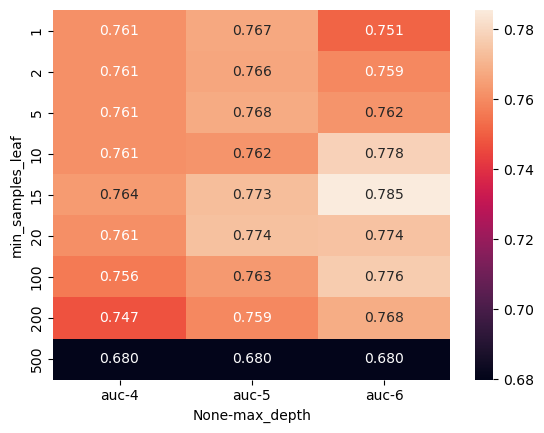

In [103]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [104]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Ensembles and random forests

- Board of experts
- ensemble models
- random forests - ensemble of decision trees
- tuning random forests

In [105]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=1) # we need to put random_state for reproducibility
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [106]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [107]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [108]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%3d -> %.3f' % (n, auc))
    scores.append((n, auc))

 10 -> 0.774
 20 -> 0.804
 30 -> 0.815
 40 -> 0.816
 50 -> 0.817
 60 -> 0.816
 70 -> 0.817
 80 -> 0.816
 90 -> 0.817
100 -> 0.818
110 -> 0.818
120 -> 0.818
130 -> 0.818
140 -> 0.818
150 -> 0.817
160 -> 0.818
170 -> 0.818
180 -> 0.817
190 -> 0.818
200 -> 0.819


In [109]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


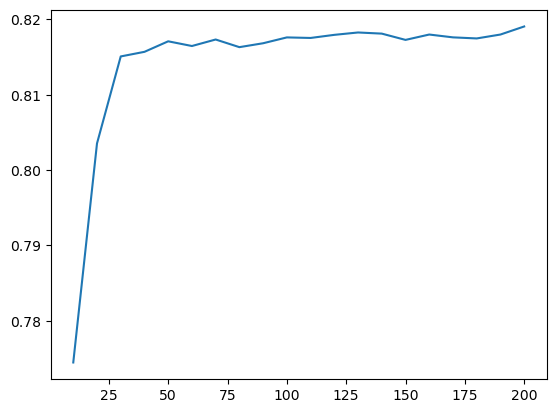

In [110]:
plt.plot(df_scores.n_estimators, df_scores.auc)

based on the plot, we need to tune with the number of max depth of trees 5, 10, 15

In [111]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%3d %3d) -> %.3f' % (d, n, auc))
        scores.append((d, n, auc))

(  5  10) -> 0.788
(  5  20) -> 0.798
(  5  30) -> 0.800
(  5  40) -> 0.800
(  5  50) -> 0.800
(  5  60) -> 0.801
(  5  70) -> 0.802
(  5  80) -> 0.803
(  5  90) -> 0.804
(  5 100) -> 0.804
(  5 110) -> 0.807
(  5 120) -> 0.806
(  5 130) -> 0.808
(  5 140) -> 0.807
(  5 150) -> 0.807
(  5 160) -> 0.807
(  5 170) -> 0.807
(  5 180) -> 0.807
(  5 190) -> 0.807
(  5 200) -> 0.807
( 10  10) -> 0.791
( 10  20) -> 0.808
( 10  30) -> 0.812
( 10  40) -> 0.818
( 10  50) -> 0.817
( 10  60) -> 0.819
( 10  70) -> 0.820
( 10  80) -> 0.820
( 10  90) -> 0.820
( 10 100) -> 0.821
( 10 110) -> 0.823
( 10 120) -> 0.823
( 10 130) -> 0.825
( 10 140) -> 0.824
( 10 150) -> 0.824
( 10 160) -> 0.825
( 10 170) -> 0.825
( 10 180) -> 0.825
( 10 190) -> 0.825
( 10 200) -> 0.825
( 15  10) -> 0.795
( 15  20) -> 0.809
( 15  30) -> 0.810
( 15  40) -> 0.813
( 15  50) -> 0.813
( 15  60) -> 0.813
( 15  70) -> 0.814
( 15  80) -> 0.815
( 15  90) -> 0.815
( 15 100) -> 0.816
( 15 110) -> 0.816
( 15 120) -> 0.818
( 15 130) ->

In [112]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802251
7,5,80,0.803244
8,5,90,0.803616
9,5,100,0.804452


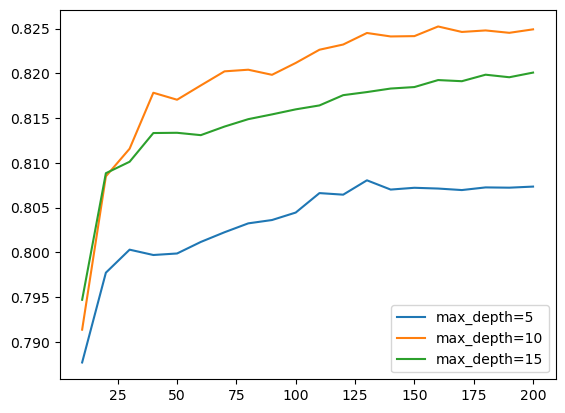

In [113]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

the best max depth is 10 then we take it out

(  1  10) -> 0.791
(  1  20) -> 0.808
(  1  30) -> 0.812
(  1  40) -> 0.818
(  1  50) -> 0.817
(  1  60) -> 0.819
(  1  70) -> 0.820
(  1  80) -> 0.820
(  1  90) -> 0.820
(  1 100) -> 0.821
(  1 110) -> 0.823
(  1 120) -> 0.823
(  1 130) -> 0.825
(  1 140) -> 0.824
(  1 150) -> 0.824
(  1 160) -> 0.825
(  1 170) -> 0.825
(  1 180) -> 0.825
(  1 190) -> 0.825
(  1 200) -> 0.825
(  3  10) -> 0.811
(  3  20) -> 0.820
(  3  30) -> 0.823
(  3  40) -> 0.822
(  3  50) -> 0.823
(  3  60) -> 0.823
(  3  70) -> 0.822
(  3  80) -> 0.823
(  3  90) -> 0.823
(  3 100) -> 0.823
(  3 110) -> 0.823
(  3 120) -> 0.825
(  3 130) -> 0.824
(  3 140) -> 0.825
(  3 150) -> 0.825
(  3 160) -> 0.826
(  3 170) -> 0.825
(  3 180) -> 0.825
(  3 190) -> 0.825
(  3 200) -> 0.825
(  5  10) -> 0.813
(  5  20) -> 0.815
(  5  30) -> 0.818
(  5  40) -> 0.820
(  5  50) -> 0.821
(  5  60) -> 0.823
(  5  70) -> 0.822
(  5  80) -> 0.823
(  5  90) -> 0.822
(  5 100) -> 0.824
(  5 110) -> 0.825
(  5 120) -> 0.825
(  5 130) ->

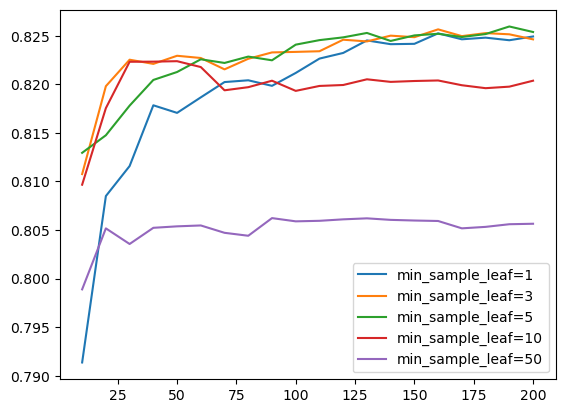

In [114]:
scores = []
max_depths = 10
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depths, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        print('(%3d %3d) -> %.3f' % (s, n, auc))
        scores.append((s, n, auc))

df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'n_estimators', 'auc'])

for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_sample_leaf=%d' % s)

plt.legend()

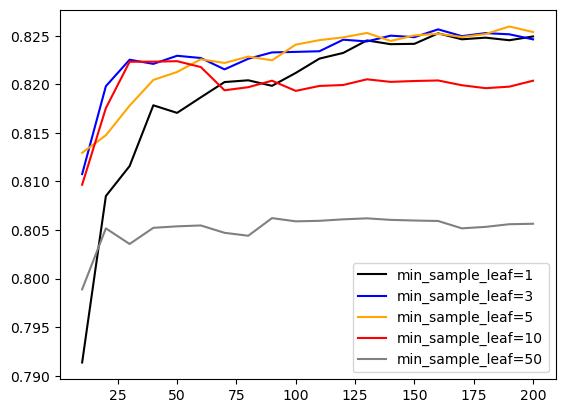

In [115]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_sample_leaf_values = [1, 3, 5, 10, 50]

for s, col in zip(min_sample_leaf_values, colors):
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label='min_sample_leaf=%d' % s)

plt.legend()

In [116]:
min_samples_leaf = 3
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depths, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other useful parameters:
- `max_features`: number of features to consider when looking for the best split
- `bootstrap`

## Gradient boosting and XGBoost

- gradient boosting vs random forests
- installing XGBoost
- training the first model
- performance monitoring
- parsing XGBoost monitoring output

In [117]:
import xgboost as xgb

In [136]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [139]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [140]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8118506454190986

In [144]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [145]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [149]:
s = output.stdout
s

'[0]\ttrain-auc:0.86653\tval-auc:0.77999\n[5]\ttrain-auc:0.92969\tval-auc:0.80822\n[10]\ttrain-auc:0.95512\tval-auc:0.81115\n[15]\ttrain-auc:0.96767\tval-auc:0.81993\n[20]\ttrain-auc:0.97648\tval-auc:0.81877\n[25]\ttrain-auc:0.98248\tval-auc:0.81520\n[30]\ttrain-auc:0.98844\tval-auc:0.81613\n[35]\ttrain-auc:0.99244\tval-auc:0.81453\n[40]\ttrain-auc:0.99393\tval-auc:0.81407\n[45]\ttrain-auc:0.99568\tval-auc:0.81392\n[50]\ttrain-auc:0.99723\tval-auc:0.81276\n[55]\ttrain-auc:0.99804\tval-auc:0.81299\n[60]\ttrain-auc:0.99861\tval-auc:0.81244\n[65]\ttrain-auc:0.99916\tval-auc:0.81197\n[70]\ttrain-auc:0.99962\tval-auc:0.81243\n[75]\ttrain-auc:0.99975\tval-auc:0.81152\n[80]\ttrain-auc:0.99989\tval-auc:0.81359\n[85]\ttrain-auc:0.99993\tval-auc:0.81193\n[90]\ttrain-auc:0.99998\tval-auc:0.81038\n[95]\ttrain-auc:0.99999\tval-auc:0.80871\n[100]\ttrain-auc:0.99999\tval-auc:0.80842\n[105]\ttrain-auc:1.00000\tval-auc:0.80778\n[110]\ttrain-auc:1.00000\tval-auc:0.80764\n[115]\ttrain-auc:1.00000\tval-au

In [163]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    df_results = pd.DataFrame(results, columns=['num_iter', 'auc_train', 'auc_val'])
        
    return df_results

In [164]:
df_scores = parse_xgb_output(output)

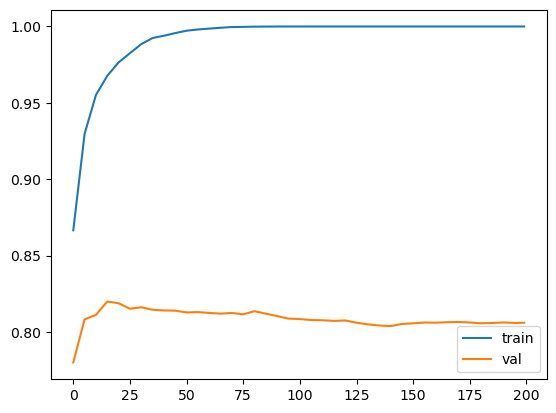

In [165]:
plt.plot(df_scores.num_iter, df_scores.auc_train, label='train')
plt.plot(df_scores.num_iter, df_scores.auc_val, label='val')
plt.legend()

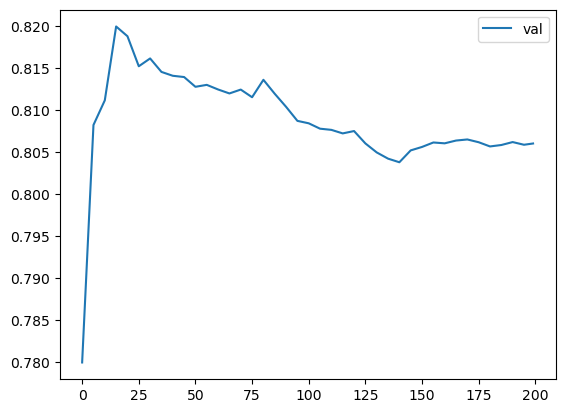

In [166]:
plt.plot(df_scores.num_iter, df_scores.auc_val, label='val')
plt.legend()

There is an overfitting here as the AUC on the training dataset is much higher than that of the validation dataset.

## XGBoost parameters tuning

Tuning the following parameters:
- `max_depth`
- `eta`
- `min_child_weight`

In [197]:
scores = {}

In [181]:
%%capture output

xgb_params = {
    'eta': 0.01, # learning rate = size of step
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [182]:
key = 'eta=%s' % xgb_params['eta']
scores[key] = parse_xgb_output(output)

In [175]:
scores['eta=0.3']

,num_iter,auc_train,auc_val
0,0,0.86653,0.77999
1,5,0.92969,0.80822
2,10,0.95512,0.81115
3,15,0.96767,0.81993
4,20,0.97648,0.81877
5,25,0.98248,0.81520
6,30,0.98844,0.81613
7,35,0.99244,0.81453
8,40,0.99393,0.81407
9,45,0.99568,0.81392


In [183]:
scores.keys()

dict_keys(['eta=1.0', 'eta=0.3', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

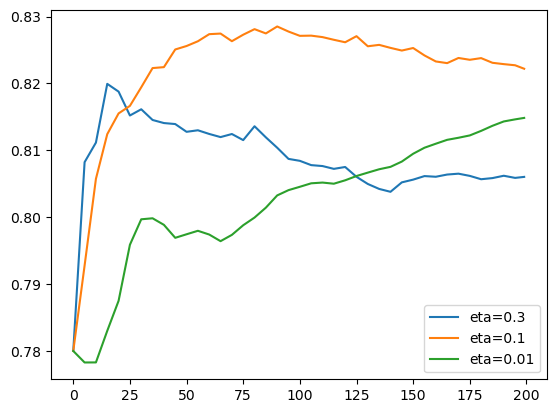

In [189]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.auc_val, label=eta)
plt.legend()

`eta=0.1` is the best learning rate parameter. lets tune other parameters based on this.

In [206]:
%%capture output

xgb_params = {
    'eta': 0.1, # learning rate = size of step
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [207]:
key = 'max_depth=%s' % xgb_params['max_depth']
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

In [208]:
scores.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=10', 'max_depth=6'])

In [210]:
del scores['max_depth=10']

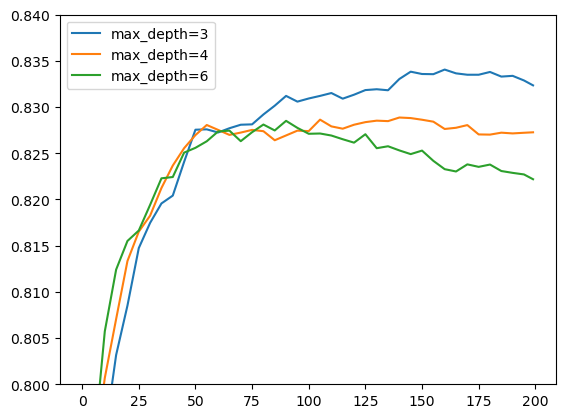

In [212]:
for max_depths, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.auc_val, label=max_depths)
plt.ylim(0.8, 0.84)
plt.legend()

In [217]:
%%capture output

xgb_params = {
    'eta': 0.1, # learning rate = size of step
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [218]:
key = 'min_child_weight=%s' % xgb_params['min_child_weight']
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [220]:
del scores['max_depth=3']
del scores['max_depth=4']
del scores['max_depth=6']

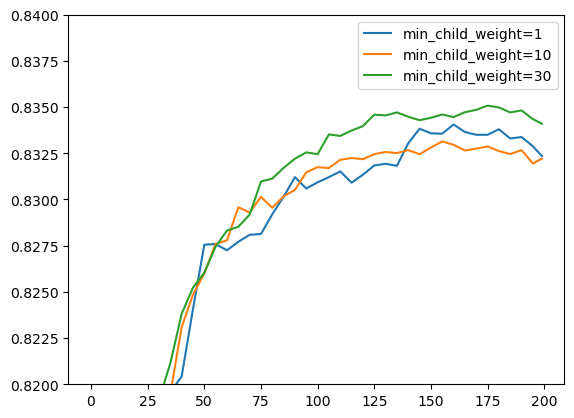

In [222]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.auc_val, label=min_child_weight)
plt.ylim(0.82, 0.84)
plt.legend()

In [ ]:
xgb_params = {
    'eta': 0.1, # learning rate = size of step
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=175, verbose_eval=5)

Useful ones:
- `subsample` and `colsample_bytree`
- `lamdba` and `alpha`

## Selecting the best model

- choosing between xgboost, random forests, and decision trees
- training the final model
- saving the model

In [ ]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

xgb_params = {
    'eta': 0.1, # learning rate = size of step
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=175, verbose_eval=5)

[0]	train-auc:0.76455	val-auc:0.73369
[5]	train-auc:0.82726	val-auc:0.77541
[10]	train-auc:0.84502	val-auc:0.79427
[15]	train-auc:0.85474	val-auc:0.80435
[20]	train-auc:0.86152	val-auc:0.81053
[25]	train-auc:0.86732	val-auc:0.81581
[30]	train-auc:0.87184	val-auc:0.81915
[35]	train-auc:0.87493	val-auc:0.82114
[40]	train-auc:0.87793	val-auc:0.82381
[45]	train-auc:0.87926	val-auc:0.82523
[50]	train-auc:0.88136	val-auc:0.82604
[55]	train-auc:0.88327	val-auc:0.82745
[60]	train-auc:0.88405	val-auc:0.82832
[65]	train-auc:0.88528	val-auc:0.82852
[70]	train-auc:0.88617	val-auc:0.82918
[75]	train-auc:0.88748	val-auc:0.83097
[80]	train-auc:0.88868	val-auc:0.83113
[85]	train-auc:0.88976	val-auc:0.83171
[90]	train-auc:0.89066	val-auc:0.83221
[95]	train-auc:0.89119	val-auc:0.83255
[100]	train-auc:0.89206	val-auc:0.83245
[105]	train-auc:0.89291	val-auc:0.83352
[110]	train-auc:0.89374	val-auc:0.83344
[115]	train-auc:0.89461	val-auc:0.83373
[120]	train-auc:0.89519	val-auc:0.83397
[125]	train-auc:0.8959

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7850954203095104

In [225]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [227]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8349852268048726

### Apply to the full training set

In [228]:
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train["status"]

dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [229]:
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [230]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [234]:
xgb_params = {
    'eta': 0.1, # learning rate = size of step
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1, 
    'eval_metric': 'auc'
}
model = xgb.train(xgb_params, dfulltrain,  num_boost_round=175, verbose_eval=5)

In [235]:
y_pred = model.predict(dtest)
y_pred[:10]

array([0.35181063, 0.28610358, 0.06789292, 0.21266344, 0.374102  ,
       0.2867889 , 0.00553958, 0.02013456, 0.23377697, 0.26151124],
      dtype=float32)

In [236]:
roc_auc_score(y_test, y_pred)

0.831618689213626

## Summary

- decision trees learn if-then-else rules from data
- finding the best split: select the least impure split. this algorithm can overfit, that's why we need to control it by limiting the max depth and the size of the group
- random forest is a way of combining multiple decision trees. it should have a diverse set of models to make good predictions
- gradient boosting trains model sequentially: each model tries to fix the errors of the previous model. XGBoost is an implementation of gradient boosting 